In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv('../raw_data/train.csv')
test = pd.read_csv('../raw_data/test.csv')

train.shape, test.shape

((8693, 14), (4277, 13))

In [4]:
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [5]:
# split train into X_train and y_train

X_train = train.drop(columns='Transported')
X_train_pipe = train.drop(columns='Transported')
y_train = train['Transported']

X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [6]:
# Drop features that we are not going to use: 'PassengerId, Name'
# I'm aware that these may hold information and can be explored as a feature, but not interested at the moment

X_train = X_train.drop(columns=['PassengerId', 'Name'])

# General EDA

In [7]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [8]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
dtypes: float64(6), object(5)
memory usage: 747.2+ KB


In [10]:
X_train.duplicated().sum()

18

In [11]:
X_train.shape, test.shape

((8693, 11), (4277, 13))

In [12]:
# Number of rows for each target

print(f"Transported: {y_train.sum()}, Not Transported: {y_train.shape[0] - y_train.sum()}")

# Train set is balanced

Transported: 4378, Not Transported: 4315


In [13]:
def quick_features(frame):
    feats_cat = []
    feats_num = []

    for col in frame.columns:
        if col in ['PassengerId']:
            continue
        elif frame[col].dtype == 'object':
            feats_cat += [col]
        else:
            feats_num += [col]

    print(f'{len(feats_cat)} categorical features \t', feats_cat)
    print(f'{len(feats_num)} numerical features \t', feats_num)

In [14]:
quick_features(X_train)

5 categorical features 	 ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
6 numerical features 	 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [15]:
# % NaN for each feature

for col in X_train.columns:
    if col in ['PassengerId', 'Transported']:
        continue
    else:
        print(f'{round(X_train[col].isnull().sum() / len(X_train) * 100, 2)} % NaN \t {col}')

2.31 % NaN 	 HomePlanet
2.5 % NaN 	 CryoSleep
2.29 % NaN 	 Cabin
2.09 % NaN 	 Destination
2.06 % NaN 	 Age
2.34 % NaN 	 VIP
2.08 % NaN 	 RoomService
2.11 % NaN 	 FoodCourt
2.39 % NaN 	 ShoppingMall
2.11 % NaN 	 Spa
2.16 % NaN 	 VRDeck


### 'Cabin' needs to be split out into three separate features

In [16]:
X_train[['Cabin_Deck', 'Cabin_Level', 'Cabin_Side']] = train['Cabin'].str.split('/', expand=True)

In [17]:
for col in ['Cabin_Deck', 'Cabin_Level', 'Cabin_Side']:
    print(f'feature: {col} \t dtype: {X_train[col].dtype} \t unique values: {len(pd.unique(X_train[col]))}')

feature: Cabin_Deck 	 dtype: object 	 unique values: 9
feature: Cabin_Level 	 dtype: object 	 unique values: 1818
feature: Cabin_Side 	 dtype: object 	 unique values: 3


In [18]:
X_train['Cabin_Level'] = pd.to_numeric(X_train['Cabin_Level'])

In [19]:
X_train.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Level,Cabin_Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S


In [20]:
sorted(X_train['Cabin_Deck'].dropna().unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [21]:
# drop old 'Cabin' Column

X_train = X_train.drop(columns='Cabin')
X_train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Level,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S


In [22]:
quick_features(X_train)

6 categorical features 	 ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']
7 numerical features 	 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Level']


### features

Numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Categorical: ['HomePlanet', 'Destination', 'Cabin Side']

Ordinal: [Cabin_Deck', 'Cabin_Level']

In [23]:
FEAT_NUM = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
FEAT_CAT = ['HomePlanet', 'Destination', 'Cabin_Side']
FEAT_ORD = ['Cabin_Deck', 'Cabin_Level']


<AxesSubplot:>

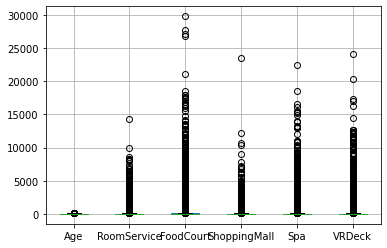

In [24]:
X_train[FEAT_NUM].boxplot()

## Preprocess Part 1: Drop Columns and split 'Cabin'

In [25]:
class DropUnusedColumns(TransformerMixin, BaseEstimator):
    """Drop PassengerId Column"""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        if 'PassengerId' in X_.columns:
            X_ = X_.drop(columns=['PassengerId'])
        X_[['CryoSleep', 'VIP']] = X_[['CryoSleep', 'VIP']].applymap(lambda x: 1 if x == True else (0 if x == False else x))
        # X_[X_['CryoSleep'] == True] = 1
        # X_[X_['CryoSleep'] == False] = 0
        # X_[X_['VIP'] == True] = 1
        # X_[X_['VIP'] == False] = 0
        return X_

In [26]:
class CabinTransform(TransformerMixin, BaseEstimator):
    """Convert 'Cabin' into three separate features, ordinally encode 'Cabin_Deck', and drop original column"""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[['Cabin_Deck', 'Cabin_Level', 'Cabin_Side']] = X_['Cabin'].str.split('/', expand=True)
        X_ = X_.drop(columns='Cabin')
        X_['Cabin_Level'] = pd.to_numeric(X_['Cabin_Level'])
        cabin_deck_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,'T': 7}
        X_['Cabin_Deck'] = X_['Cabin_Deck'].dropna().apply(lambda x: cabin_deck_dict[x])
        return X_

In [27]:
cabin_deck_dict = {'A': 0,
                          'B': 1,
                          'C': 2,
                          'D': 3,
                          'E': 4,
                          'F': 5,
                          'G': 6,
                          'T': 7}
cabin_deck_dict

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}

In [28]:
X_train3 = X_train.copy()
X_train3['Cabin_Deck'] = X_train['Cabin_Deck'].map(cabin_deck_dict)

In [29]:
X_train3['Cabin_Deck'].unique()

array([ 1.,  5.,  0.,  6., nan,  4.,  3.,  2.,  7.])

In [30]:
X_train3.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Level,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,5.0,0.0,S


In [31]:
preproc_part1 = make_pipeline(DropUnusedColumns(), CabinTransform())
preproc_part1

Pipeline(steps=[('dropunusedcolumns', DropUnusedColumns()),
                ('cabintransform', CabinTransform())])

In [32]:
X_train_pipe.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines


In [33]:
X_train_transformed1 = preproc_part1.fit_transform(X_train_pipe)
X_train_transformed1.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_Deck,Cabin_Level,Cabin_Side
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1.0,0.0,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,5.0,0.0,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,0.0,S


In [34]:
X_train_transformed1.CryoSleep.unique()

array([ 0.,  1., nan])

In [35]:
X_train_transformed1['CryoSleep'].isnull().sum()

217

## Preprocessing Part 2: Numerical, Categorical, and Ordinal Pipes

Impute missing values for each

In [36]:
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

Scaling for each data type

In [37]:
# Robust for numeric
r_scaler = RobustScaler()

# MinMax for Ordinal
mm_scaler = MinMaxScaler()

# OneHotEncoding for Multi-Categorical
ohe = OneHotEncoder(sparse=False)

In [38]:
num_transform = make_pipeline(mean_imputer, r_scaler)
cat_transform = make_pipeline(mode_imputer, ohe)
ord_transform = make_pipeline(mode_imputer, mm_scaler)

In [39]:
preproc_part2 = make_column_transformer(
                                (num_transform, FEAT_NUM), 
                                (cat_transform, FEAT_CAT),
                                (ord_transform, FEAT_ORD),
    )

In [40]:
preproc_part2

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['HomePlanet', 'Destination', 'Cabin_Side']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Cabin_Deck', 'Cabin_Level'])])

In [41]:
preproc = make_pipeline(preproc_part1, preproc_part2)

In [42]:
preproc

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropunusedcolumns', DropUnusedColumns()),
                                 ('cabintransform', CabinTransform())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['HomePlanet', 'Destination',
                                                   'Cabin_Side']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Cabin_Deck',
                                                   'Cabin_Level'])]))])

In [43]:
log_model = LogisticRegression(max_iter=1000)

In [44]:
log_model_pipe = make_pipeline(preproc, log_model)
log_model_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('dropunusedcolumns',
                                                   DropUnusedColumns()),
                                                  ('cabintransform',
                                                   CabinTransform())])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall...
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(sparse=False))]),
                                                                   ['HomePlanet',
                                                                    'Destination',
                                                                    'Cabin_Side']),
                                                                  ('pipeline-3',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Cabin_Deck',
                                                                    'Cabin_Level'])]))])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [45]:
X_train2 = train.drop(columns='Transported')

In [46]:
X_train2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [47]:
cv_score = cross_validate(log_model_pipe, X_train2, y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [61]:
display(cv_score['test_score'])
display(cv_score['test_score'].mean())

array([0.76365727, 0.77113283, 0.78378378, 0.79113924, 0.76467204])

0.7748770340744484

In [58]:
train_nona = train.dropna()
X_train_nona, y_train_nona = train_nona.drop(columns='Transported'), train_nona['Transported']

In [59]:
X_train_nona.shape, y_train_nona.shape

((6606, 13), (6606,))

In [62]:
cv_score_nona = cross_validate(log_model_pipe, X_train_nona, y_train_nona, cv=5, scoring='accuracy', n_jobs=-1)
display(cv_score_nona['test_score'])
display(cv_score_nona['test_score'].mean())

array([0.76701967, 0.77744133, 0.79333838, 0.81226344, 0.77214232])

0.7844410265454699